1. 의사결정나무(Decision Tree)
- 특성(features)를 기준으로 샘플을 분류하는 트리 모델.    
- 회귀문제, 분류문제에 모두 적용이 가능하다.    
- 장점 : 
- + 분석 결과를 액션플랜으로 활용하기 좋다.    
- + 분류문제, 회귀문제 모두 사용
- 단점 :
- + 과적합(over fitting)이 되기 쉬운 모델이다. (일반화 예측 성능이 떨어진다.)
2. 노드(node)와 엣지(edge)     
- 결정 트리에서 샘플을 분류할 때 사용하는 질문이나 그에 따른 값을 나타낸다.   
- 뿌리노드(root) : 의사결정나무의 첫번째 노드. 지니 불순도가 가장 최소인 특성이 루트 노드가 된다.   
- 중간노드(internal node) : 중간노드. 노드의 특성은 지니불순도의 감소가 가장 큰(Information Gain가 최대가 되는) 지점의 특성으로 결정    
- 말단노드(external node) : 결정트리의 가장 밑. 최종 결론은 분류모델에서는 다수 샘플을 가진 클래스로 결정, 회귀 모델에서는 평균으로 결정한다.    
3. 지니불순도(Gini Impurity)     
- 결정트리 모델 중 (CART)알고리즘의 비용함수(Cost function)    
- 불순도 : 여러 범주가 섞여있는 정도
- 이 불순도를 최소화할 수 있는 지점을 선택한다.    
- 정보획득(Information Gain) : 특정한 특성을 사용해서 분할했을 때 엔트로피 감소량. (엔트로피 감소량이 최대가 되는 지점 = 불순도 감소가 가장 큰 지점)    
4. 특성중요도(feature importance)
- 해당 특성으로 분기했을 때 지니 불순도의 총 감소량. 높을수록 의사결정나무의 분류 성능에 중요한 영향을 미치는 특성
- 단, high-cardinality한 경우 불순도 감소량이 매우 높게 나타나서 중요한 컬럼으로 보일 수 있다. 이 경우 permutation_importance를 보는 것이 좋다.    

In [202]:
import pandas as pd
load_df = pd.read_csv('../loan_data.csv')
print(load_df.head())
print(load_df.info())
print(load_df.isna().sum())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001003   Male     Yes          1      Graduate            No   
1  LP001005   Male     Yes          0      Graduate           Yes   
2  LP001006   Male     Yes          0  Not Graduate            No   
3  LP001008   Male      No          0      Graduate            No   
4  LP001013   Male     Yes          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4583             1508.0       128.0             360.0   
1             3000                0.0        66.0             360.0   
2             2583             2358.0       120.0             360.0   
3             6000                0.0       141.0             360.0   
4             2333             1516.0        95.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Rural           N  
1             1.0         Urban           Y  
2             1.0   

In [203]:
print(load_df.Dependents.value_counts()) #이런식으로 해당 열 체크 가능

Dependents
0     234
2      59
1      52
3+     28
Name: count, dtype: int64


In [204]:
load_df['Dependents'] = load_df['Dependents'].str.split('+',expand=True)[0] #3명 이상 3명으로 처리
load_df['Dependents'] = load_df['Dependents'].fillna(0)
load_df['Dependents'] = load_df['Dependents'].astype(int)


In [205]:
print(load_df.dtypes)

Loan_ID               object
Gender                object
Married               object
Dependents             int32
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


In [206]:
#target을 Loan_Status로 설정
print(load_df['Loan_Status'])
load_df['Loan_Status'] = load_df['Loan_Status'].apply(lambda x : 1 if x == 'Y' else 0)
print(load_df['Loan_Status'])

0      N
1      Y
2      Y
3      Y
4      Y
      ..
376    Y
377    Y
378    Y
379    Y
380    N
Name: Loan_Status, Length: 381, dtype: object
0      0
1      1
2      1
3      1
4      1
      ..
376    1
377    1
378    1
379    1
380    0
Name: Loan_Status, Length: 381, dtype: int64


In [207]:
from sklearn.model_selection import train_test_split
target = "Loan_Status"
train,val = train_test_split(load_df,train_size=0.8,test_size=0.2,stratify=load_df[target],random_state=42)
#stratify 는 나눌 때 클래스 비율까지 맞춰준다.

In [208]:
print(load_df.columns.drop('Loan_Status'))
features = load_df.columns.drop('Loan_Status')

y_train = train[target]
X_train = train[features]
y_test = val[target]
X_test = val[features]

print(y_test.shape,X_test.shape,y_train.shape,X_train.shape)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')
(77,) (77, 12) (304,) (304, 12)


In [209]:
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder
encoder = OrdinalEncoder()
from sklearn.impute import SimpleImputer #결측치를 채워준다.
imputer = SimpleImputer()

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
print(X_train_encoded.shape)
model = DecisionTreeClassifier(max_depth=7)
model.fit(X_train_imputed,y_train)

X_val_encoded = encoder.fit_transform(X_test)
X_val_imputed = imputer.fit_transform(X_val_encoded)

print('테스트 정확도',model.score(X_val_imputed,y_test))

(304, 12)
테스트 정확도 0.8441558441558441


In [210]:
encoder_params = encoder.get_params()
columns_names = encoder_params['cols']
print(columns_names)

['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']


In [211]:
mapping_info = encoder_params['mapping']
print(mapping_info) #encoder가 뭘 어떻게 변경시켜놨는지 확인할 수 있다.

[{'col': 'Loan_ID', 'mapping': LP002244     1
LP002990     2
LP002226     3
LP001514     4
LP001259     5
            ..
LP002181    74
LP002586    75
LP002297    76
LP001264    77
NaN         -2
Length: 78, dtype: int64, 'data_type': dtype('O')}, {'col': 'Gender', 'mapping': Male      1
Female    2
NaN      -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'Married', 'mapping': Yes    1
No     2
NaN   -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'Education', 'mapping': Graduate        1
Not Graduate    2
NaN            -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'Self_Employed', 'mapping': No     1
Yes    2
NaN    3
dtype: int64, 'data_type': dtype('O')}, {'col': 'Property_Area', 'mapping': Urban        1
Semiurban    2
Rural        3
NaN         -2
dtype: int64, 'data_type': dtype('O')}]


In [212]:
values_names = []
values_encoded = []
values = []

for col_mapping in mapping_info:
    col_name = col_mapping['col']
    mapping = col_mapping['mapping']
    if mapping is not None:
        for value_name, encoded_number in mapping.items():
            values_names.append(col_name)
            values.append(value_name)
            values_encoded.append(encoded_number)

mapping_df = pd.DataFrame({
    'Column' : values_names,
    'Value Name' : values,
    'Encoded Number' : values_encoded
})

print(mapping_df)

#어떻게 인코딩했는지 보여줌 그냥 mapping으로 보는게 나을듯

           Column Value Name  Encoded Number
0         Loan_ID   LP002244               1
1         Loan_ID   LP002990               2
2         Loan_ID   LP002226               3
3         Loan_ID   LP001514               4
4         Loan_ID   LP001259               5
..            ...        ...             ...
89  Self_Employed        NaN               3
90  Property_Area      Urban               1
91  Property_Area  Semiurban               2
92  Property_Area      Rural               3
93  Property_Area        NaN              -2

[94 rows x 3 columns]


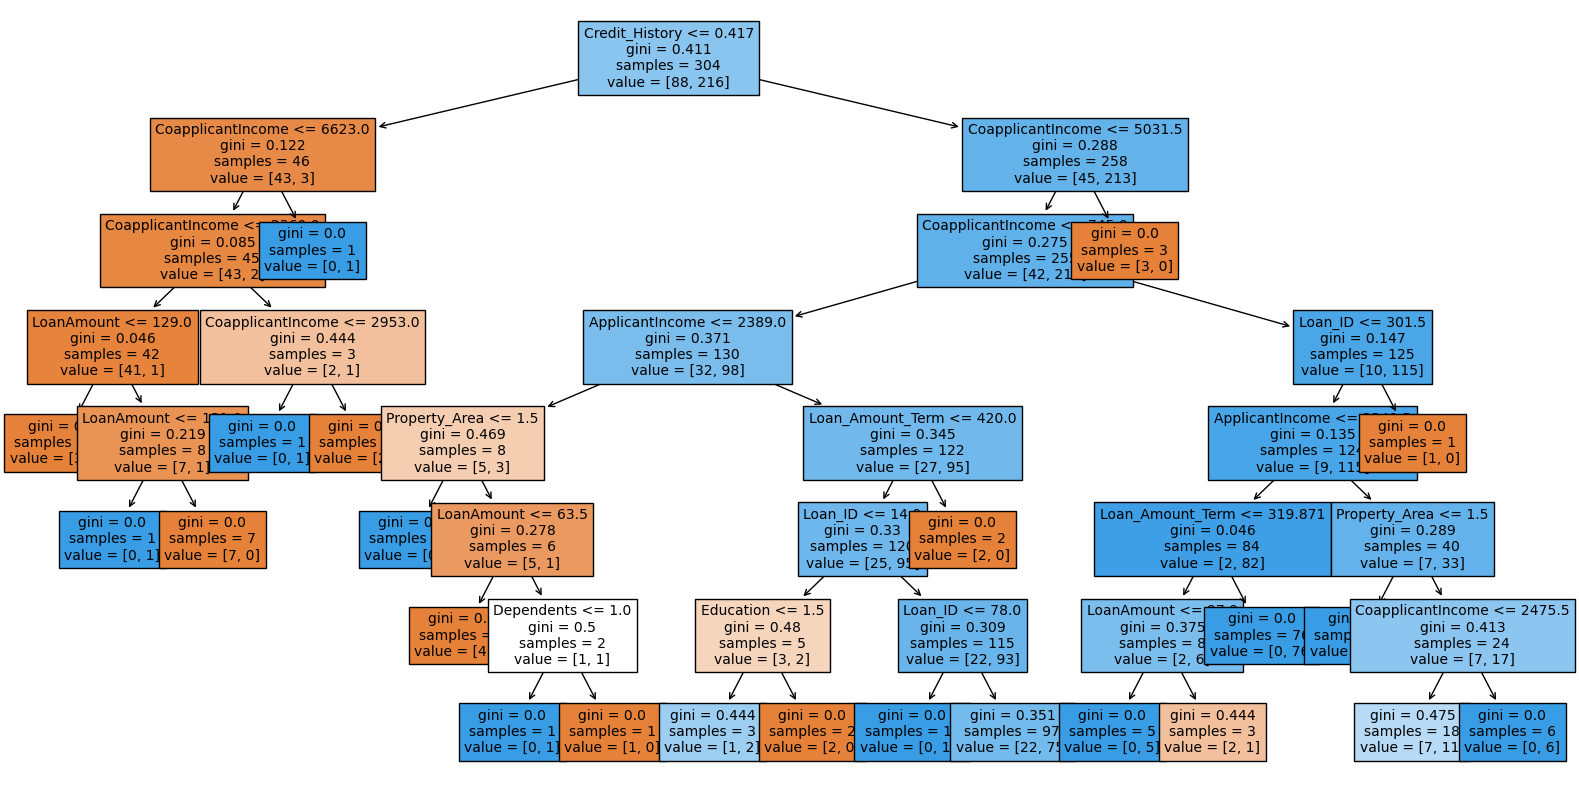

In [213]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(model,filled=True,feature_names=list(X_train_encoded.columns),fontsize=10)
plt.show()

In [214]:
# 특성 중요도 출력
importance = model.feature_importances_
feature_im_df = pd.DataFrame({
    'Feat':X_train_encoded.columns,
    'importance':importance
})
print(feature_im_df.sort_values('importance',ascending=False))


                 Feat  importance
10     Credit_History    0.565615
7   CoapplicantIncome    0.158798
0             Loan_ID    0.061010
8          LoanAmount    0.053699
11      Property_Area    0.046569
6     ApplicantIncome    0.046182
9    Loan_Amount_Term    0.042233
4           Education    0.013365
3          Dependents    0.012530
1              Gender    0.000000
2             Married    0.000000
5       Self_Employed    0.000000


2. K-평균군집분석(K-means Clustering)
- 유사한 그룹을 묶는 알고리즘. 전체 데이터 중 K개 그룹의 평균값을 중심으로(거리) 데이터를 그룹화한다.
- 각 클러스터별 중심점에서 클러스터 내 data point 간의 거리의 제곱합을 최소로하는 집합을 찾는다.    
- + 중심점(centroid) : 클러스터 내부 모든 데이터포인트들의 가장 중심 부분에 위치한 가상의 점
- + 중심점과 각 데이터 포인트들 간의 거리는 유클리드거리 맨해튼거리 등을 사용한다.    
- + K를 몇개로 설정하냐에 따라서 결과가 달라진다.    
- 최적의 K를 설정하는 방법
- + 실무에서 필요에 의해 직관적으로 선정하는 방법   
- + CCC통계량(Cubic Clustering Criterion), 스크리플랏(Scree plot), 엘보우메소드(Elbow Method)를 활용해 K를 선정할 수 있다.       


실행 순서 정리
- K개의 중심을 랜덤으로 생성한다.
- 모든 데이터 포인트들은 k개의 중심과 거리를 계산해서 가장 가까운 중심점에 배정
- 클러스터들이 k개 완성되면 그 클러스터 안에 data point들의 평균으로 새로운 중심점 생성
- 위의 과정을 반복

In [215]:
customer = pd.read_csv('../customer_segmentation.csv')
print(customer.head())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

In [216]:
print(customer.shape)
print(customer.columns)

(2240, 29)
Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [217]:
#2개의 feature만 사용
feat = ['Recency','NumCatalogPurchases']
X = customer[feat]
print(X.head())

   Recency  NumCatalogPurchases
0       58                   10
1       38                    1
2       26                    2
3       26                    0
4       94                    3


In [218]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[ 0.30703926  2.51089024]
 [-0.38366418 -0.56871962]
 [-0.79808624 -0.22654075]
 ...
 [ 1.44669994  0.11563813]
 [-1.41971934  0.79999587]
 [-0.31459383 -0.56871962]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

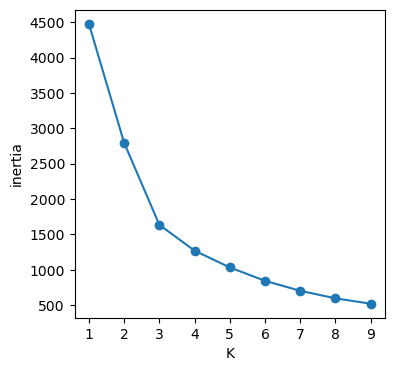

In [219]:
from sklearn.cluster import KMeans

search_k = range(1,10) #1-9에서 k탐색
inertias = [] #inertia는 데이터들이 k-means clustering에 대해서 얼마나 잘 클러스터되어있는지 나타내는 값이다.

for k in search_k:
    model = KMeans(n_clusters=k)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(4,4))
plt.plot(search_k,inertias,'-o')
plt.xlabel('K')
plt.ylabel('inertia')
plt.xticks(search_k)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


[4 3 1 ... 0 7 3]


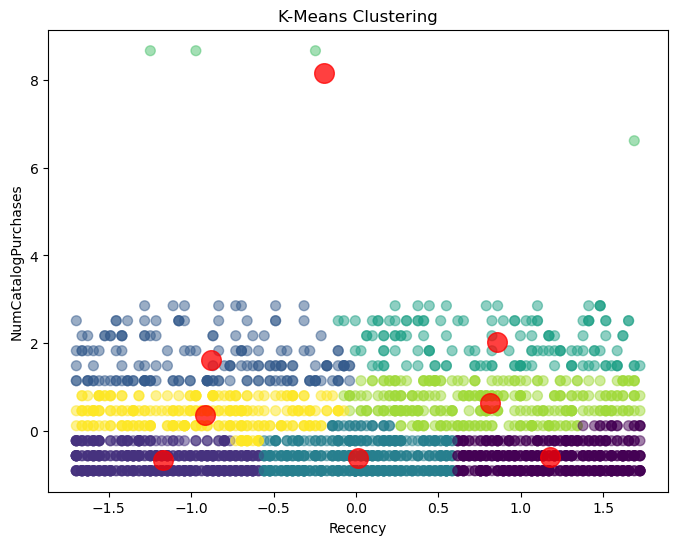

In [220]:
import numpy as np

data = X_scaled
kmeans = KMeans(n_clusters=8,random_state=42)
kmeans.fit(data)

centers = kmeans.cluster_centers_ #각 클러스터들의 센터

y_kmeans = kmeans.predict(data)
print(y_kmeans)
# Visualize the clusters
plt.figure(figsize=(8, 6))

# Scatter plot of the data points colored by cluster label
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.5)

# Plotting cluster centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75)

plt.xlabel('Recency')
plt.ylabel('NumCatalogPurchases')
plt.title('K-Means Clustering')
#plt.legend(range(8))
plt.show()


In [221]:
#여러개의 feature로 클러스터링 해보자

features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

X = customer[features]
print(X.head())

   Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  Recency  \
0        1957  Graduation         Single  58138.0        0         0       58   
1        1954  Graduation         Single  46344.0        1         1       38   
2        1965  Graduation       Together  71613.0        0         0       26   
3        1984  Graduation       Together  26646.0        1         0       26   
4        1981         PhD        Married  58293.0        1         0       94   

   MntWines  MntFruits  MntMeatProducts  ...  NumWebVisitsMonth  AcceptedCmp3  \
0       635         88              546  ...                  7             0   
1        11          1                6  ...                  5             0   
2       426         49              127  ...                  4             0   
3        11          4               20  ...                  6             0   
4       173         43              118  ...                  5             0   

   AcceptedCmp4  AcceptedC

In [222]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder()
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')#평균으로 채워줌

#feature이 numeric한지 categoric한지 나눠줌
print(X.dtypes)

Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object


In [223]:
categorical_features = ['Education', 'Marital_Status']
numeric_features = ['Year_Birth', 'Income', 'Kidhome',
                    'Teenhome', 'Recency', 'MntWines', 'MntFruits',
                    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                    'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                    'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

In [224]:
numeric_transformer = Pipeline(steps=
                               [('imputer',SimpleImputer(strategy='mean')),
                                ('scaler',StandardScaler())])

categorical_transformer = Pipeline(steps=
                                   [('imputer',SimpleImputer(strategy='most_frequent')),
                                     ('onehot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features)
    ]
)
X_prepro = preprocessor.fit_transform(X)
print(X_prepro)

[[-0.98534473  0.23532677 -0.82521765 ...  0.          0.
   0.        ]
 [-1.23573295 -0.23582624  1.03255877 ...  0.          0.
   0.        ]
 [-0.3176428   0.77363327 -0.82521765 ...  1.          0.
   0.        ]
 ...
 [ 1.01776106  0.18910632 -0.82521765 ...  0.          0.
   0.        ]
 [-1.06880747  0.67903514 -0.82521765 ...  1.          0.
   0.        ]
 [-1.23573295  0.02483795  1.03255877 ...  0.          0.
   0.        ]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

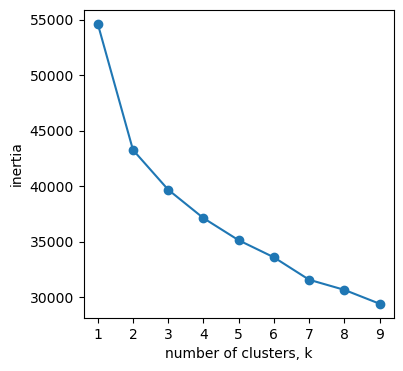

In [225]:
ks = range(1,10)
inertias = []

X = X_prepro
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [226]:
kmeans = KMeans(n_clusters=9,random_state=42)
kmeans.fit(X)

pred = kmeans.predict(X)
print(pred)
customer['cluster'] = pred
print(customer.head())

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


[0 6 4 ... 4 4 6]
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  AcceptedCmp3  AcceptedCmp4  \
0  04-09-2012       58       635  ...             0             0   
1  08-03-2014       38        11  ...             0             0   
2  21-08-2013       26       426  ...             0             0   
3  10-02-2014       26        11  ...             0             0   
4  19-01-2014       94       173  ...             0             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  \
0             0           

k-means 클러스터링 할 때 k를 설정한다.     
하지만 k를 설정할 때 inertia를 보는데, 큰 차이가 없다면 작은 k를 설정하는 것이 컴퓨팅 자원 관리 차원에서 좋다.    